In [25]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
sys.path.insert(1, '/home/jupyter/ds_toolkit')
from ds_toolkit import tools
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

In [28]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [37]:
dataset = pd.read_csv('timeseries_data.csv',parse_dates=['usage_date'],index_col='usage_date')

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1603 entries, 2016-01-01 00:00:00+00:00 to 2020-05-24 00:00:00+00:00
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1603 non-null   int64  
 1   account_id           1603 non-null   int64  
 2   acct_ttl_unit_hours  1603 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 50.1 KB


In [39]:
dataset.head()

,Unnamed: 0,account_id,acct_ttl_unit_hours
usage_date,,,
2016-01-01 00:00:00+00:00,0,615281,13920.0
2016-01-02 00:00:00+00:00,1,615281,13920.0
2016-01-03 00:00:00+00:00,2,615281,13920.0
2016-01-04 00:00:00+00:00,3,615281,13920.0
2016-01-05 00:00:00+00:00,4,615281,13920.0


In [40]:
dataset = dataset[['acct_ttl_unit_hours']]

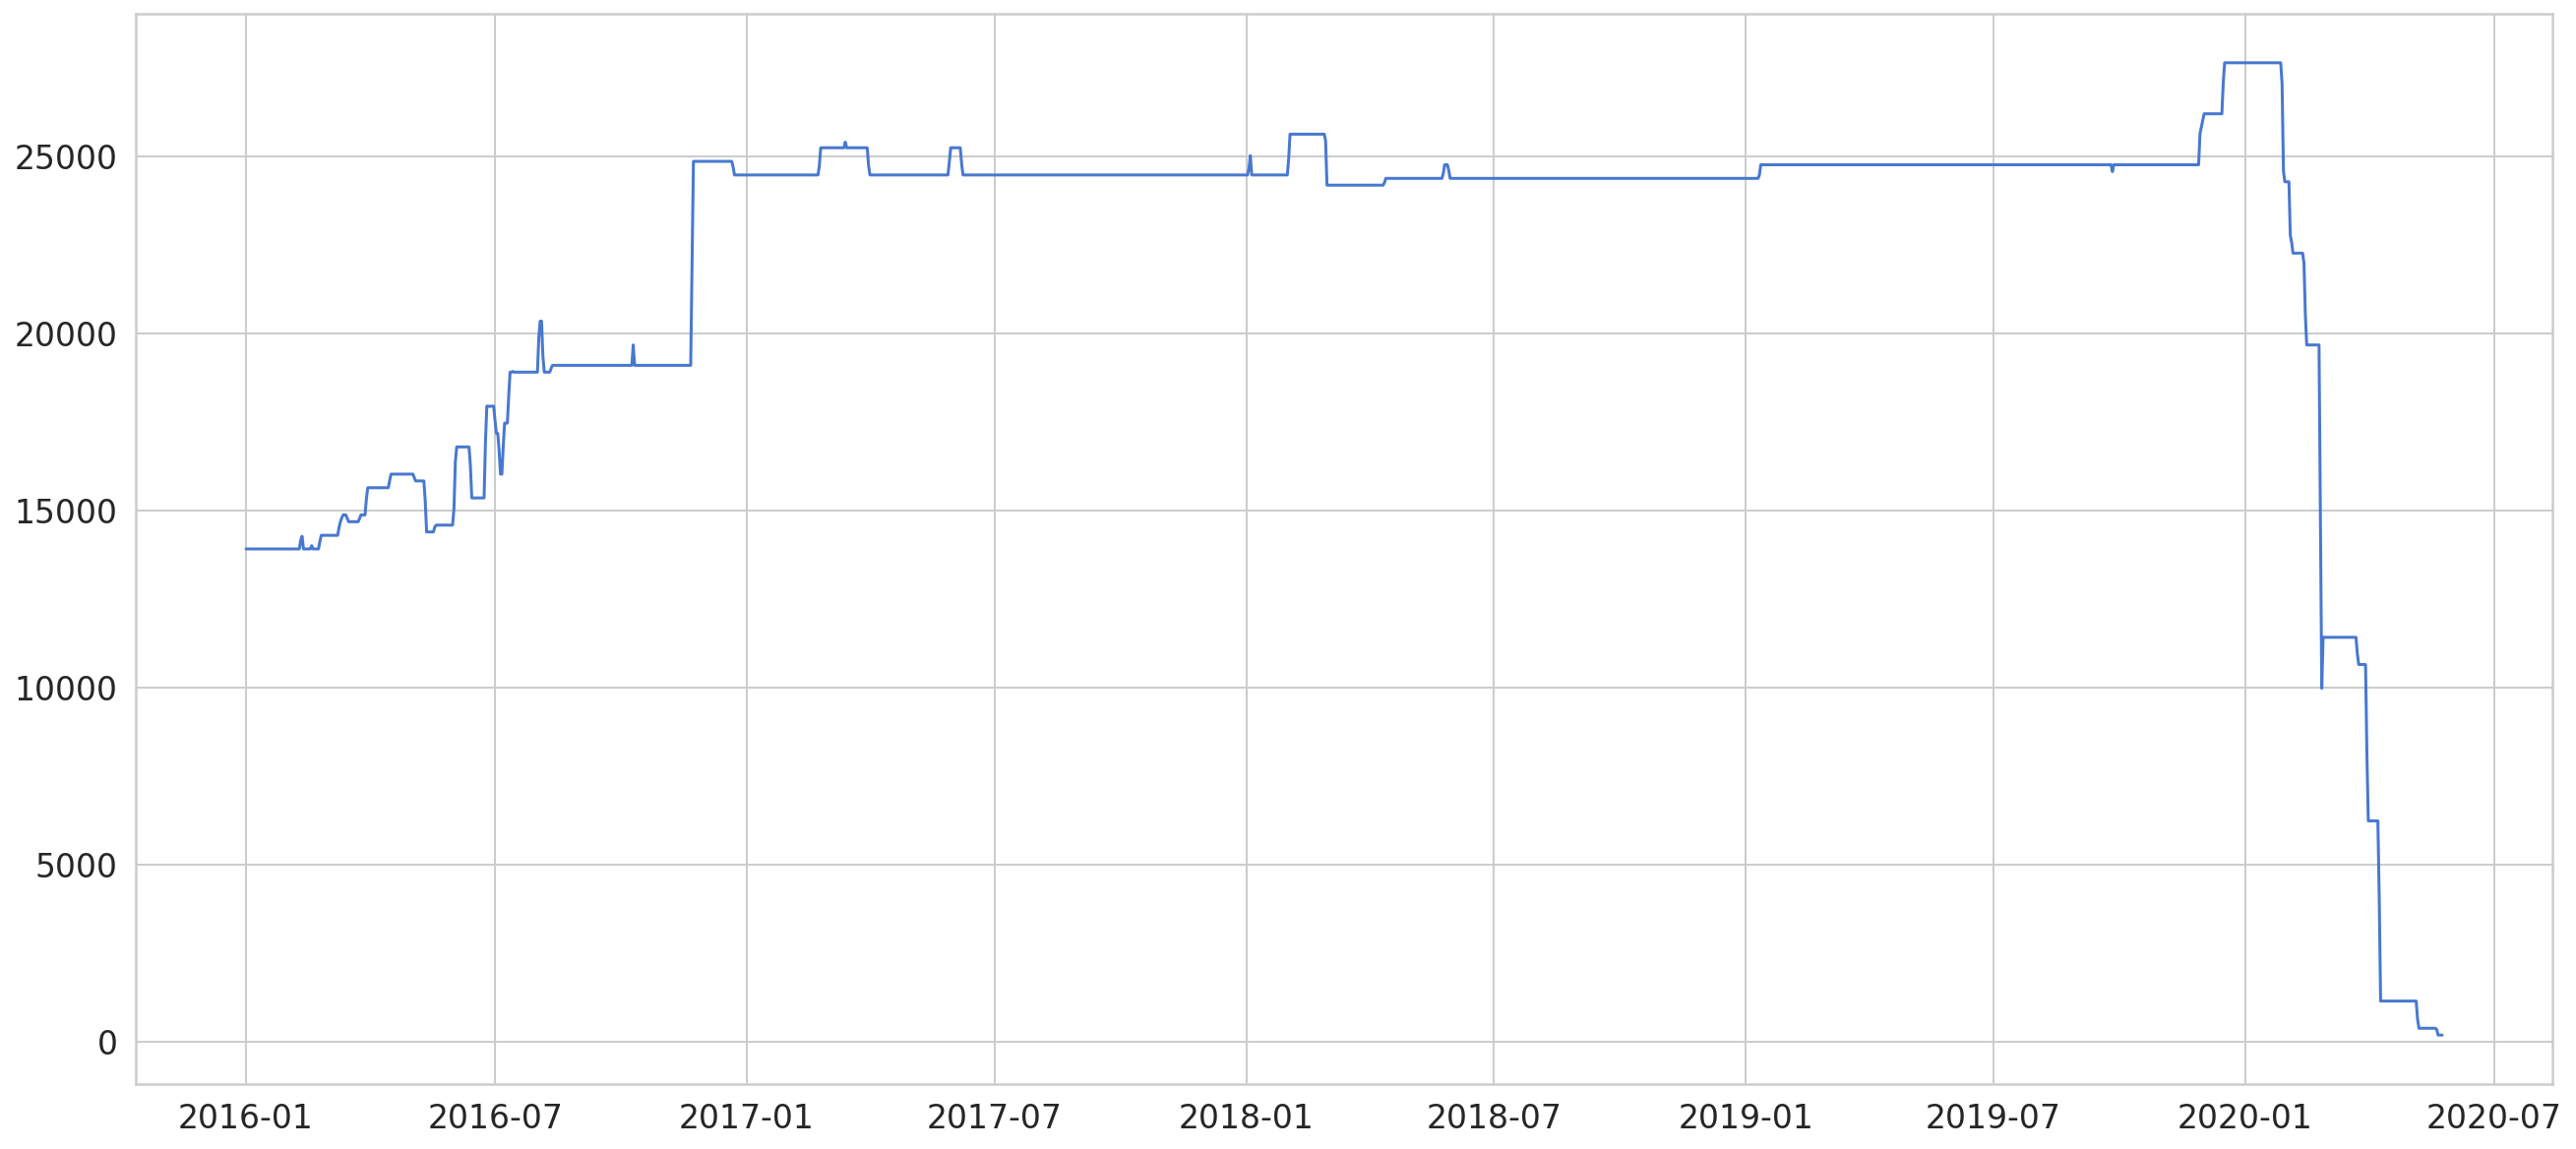

In [43]:
plt.plot(dataset.index,dataset.acct_ttl_unit_hours)

## split the data

In [46]:
train_size = int(len(dataset)*0.9)
test_size = len(dataset) - train_size

train, test = dataset.iloc[0:train_size],dataset.iloc[train_size:len(dataset)]
print(train.shape,test.shape)

(1442, 1) (161, 1)


## scale the data

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['acct_ttl_unit_hours']])

In [50]:
#apply transformation
train['acct_ttl_unit_hours'] = scaler.transform(train[['acct_ttl_unit_hours']])
test['acct_ttl_unit_hours'] = scaler.transform(test[['acct_ttl_unit_hours']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [51]:
train.head()

,acct_ttl_unit_hours
usage_date,
2016-01-01 00:00:00+00:00,-2.57442
2016-01-02 00:00:00+00:00,-2.57442
2016-01-03 00:00:00+00:00,-2.57442
2016-01-04 00:00:00+00:00,-2.57442
2016-01-05 00:00:00+00:00,-2.57442


In [52]:
def create_dataset(X,y,time_steps=1):
    Xs, ys = [],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [53]:
TIME_STEPS = 30

X_train, y_train = create_dataset(train[['acct_ttl_unit_hours']],train.acct_ttl_unit_hours,TIME_STEPS)
X_test, y_test = create_dataset(test[['acct_ttl_unit_hours']],test.acct_ttl_unit_hours,TIME_STEPS)

In [54]:
X_train.shape

(1412, 30, 1)

# LSTM Autoencoder